# Seq2Seq_code

ps：

pip install d2l

pip install matplotlib==3.0.0

In [1]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
from model import RNN
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import collections
import re
import numpy as np

## Trasnlation Text Preprocessing

In [2]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
  '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
  """载⼊“英语－法语”数据集"""
  data_dir = d2l.download_extract('fra-eng')
  with open(os.path.join(data_dir, 'fra.txt'), 'r',
  encoding='utf-8') as f:
    return f.read()
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [3]:
def preprocess_nmt(text):
  """预处理“英语－法语”数据集"""
  def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' '

  # 使⽤空格替换不间断空格
  # 使⽤⼩写字⺟替换⼤写字⺟
  text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
  # 在单词和标点符号之间插⼊空格
  out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
      for i, char in enumerate(text)]
  return ''.join(out)
  
text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [4]:
def tokenize_nmt(text, num_examples=None):
  """词元化“英语－法语”数据数据集"""
  source, target = [], []
  for i, line in enumerate(text.split('\n')):
    if num_examples and i > num_examples:
      break
    parts = line.split('\t')
    if len(parts) == 2:
      source.append(parts[0].split(' '))
      target.append(parts[1].split(' '))
  return source, target
  
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

In [5]:
src_vocab = RNN.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [6]:
def truncate_pad(line, num_steps, padding_token):
  """截断或填充⽂本序列"""
  if len(line) > num_steps:
    return line[:num_steps] # 截断
  return line + [padding_token] * (num_steps - len(line)) # 填充
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [7]:
def build_array_nmt(lines, vocab, num_steps):
  """将机器翻译的⽂本序列转换成⼩批量"""
  lines = [vocab[l] for l in lines]
  lines = [l + [vocab['<eos>']] for l in lines]
  array = torch.tensor([truncate_pad(
      l, num_steps, vocab['<pad>']) for l in lines])
  valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
  return array, valid_len

In [8]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
  """返回翻译数据集的迭代器和词表"""
  text = preprocess_nmt(read_data_nmt())
  source, target = tokenize_nmt(text, num_examples)
  src_vocab = RNN.Vocab(source, min_freq=2,
            reserved_tokens=['<pad>', '<bos>', '<eos>'])
  tgt_vocab = d2l.Vocab(target, min_freq=2,
            reserved_tokens=['<pad>', '<bos>', '<eos>'])
  src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
  tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
  data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
  data_iter = DataLoader(dataset=TensorDataset(*data_arrays), 
                 batch_size=batch_size, shuffle=True)
  return data_iter, src_vocab, tgt_vocab

In [9]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
  print('X:', X.type(torch.int32))
  print('X的有效⻓度:', X_valid_len)
  print('Y:', Y.type(torch.int32))
  print('Y的有效⻓度:', Y_valid_len)
  break

X: tensor([[ 71,   5,   3,   1,   1,   1,   1,   1],
        [109,  10,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效⻓度: tensor([3, 4])
Y: tensor([[15,  0, 98,  5,  3,  1,  1,  1],
        [92,  8,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效⻓度: tensor([5, 4])


## Seq2Seq

序列到序列学习——以机器翻译为例

机器翻译中的输入序列和输出序列都是⻓度可变的。为了解决这类问题，我们将使用两个循环神经网络的编码器和解 码器，并将其应用于序列到序列(sequence to sequence，seq2seq)类的学习任务.

![title](attachment/seq2seq.png)

特定的“\<eos>”表示序列结束词元。一旦输出序列生成此词元，模型就会停止预测。在循环神
经网络解码器的初始化时间步，有两个特定的设计决定:首先，特定的“\<bos>”表示序列开始词元，它是解码器的输入序列的第一个词元。其次，使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态。

根据Encoder-Decoder来设计网络
![title](attachment/seq2seq2.png)

- Seq2Seq Encoder

In [10]:
class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
               dropout=0, **kwargs):
    super().__init__(**kwargs)
    # embedding
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

  def forward(self, X, *args):
    # 输出'X'的形状：(batch_size,num_steps,embed_size)
    X = self.embedding(X)
    X = X.permute(1, 0, 2)
    output, state = self.rnn(X)
    return output, state

In [11]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

- Seq2Seq Decoder

In [12]:
class Seq2SeqDecoder(nn.Module):
  """⽤于序列到序列学习的循环神经⽹络解码器"""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
          dropout=0, **kwargs):
    super().__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, *args):
    return enc_outputs[1]

  def forward(self, X, state):
    X = self.embedding(X).permute(1, 0, 2)
    context = state[-1].repeat(X.shape[0], 1, 1)
    X_and_context = torch.cat((X, context), 2)
    # return X, context
    output, state = self.rnn(X_and_context, state)
    output = self.dense(output).permute(1, 0, 2)
    return output, state

In [13]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
      num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [14]:
class EncoderDecoder(nn.Module):
  """编码器-解码器架构的基类"""
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_X, dec_X, *args):
    enc_outputs = self.encoder(enc_X, *args)
    dec_state = self.decoder.init_state(enc_outputs, *args)
    return self.decoder(dec_X, dec_state)

- loss

In [15]:
def sequence_mask(X, valid_len, value=0):
  """在序列中屏蔽不相关的项"""
  maxlen = X.size(1)
  mask = torch.arange((maxlen), dtype=torch.float32,
          device=X.device)[None, :] < valid_len[:, None]
  X[~mask] = value
  return X

In [16]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [17]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
  """带遮蔽的softmax交叉熵损失函数"""
  # pred的形状：(batch_size,num_steps,vocab_size)
  # label的形状：(batch_size,num_steps)
  # valid_len的形状：(batch_size,)
  def forward(self, pred, label, valid_len):
    weights = torch.ones_like(label)
    weights = sequence_mask(weights, valid_len)
    self.reduction='none'
    unweighted_loss = super().forward(
                pred.permute(0, 2, 1), label)
    weighted_loss = (unweighted_loss * weights).mean(dim=1)
    return weighted_loss

loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
        torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

- Train

特定的序列开始词元(“<bos>”)和原始的输出序列(不包括序 列结束词元“<eos>”)拼接在一起作为解码器的输入。这被称为强制教学(teacher forcing)，因为原始的输 出序列(词元的标签)被送入解码器。或者，将来自上一个时间步的预测得到的词元作为解码器的当前输入。

In [18]:
# 1.载入数据集
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
len(src_vocab), len(tgt_vocab)

(184, 201)

In [19]:
# 2.定义网络
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                dropout)
net = EncoderDecoder(encoder, decoder)

In [20]:
# 3.初始化weight
def xavier_init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
  if type(m) == nn.GRU:
    for param in m._flat_weights_names:
      if "weight" in param:
        nn.init.xavier_uniform_(m._parameters[param])

net.apply(xavier_init_weights)

# 4.定义losss和optimizer
loss = MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [21]:
# Train
def train_seq2seq(net, epochs, train_iter, loss, optim, tgt_vocab,
  grad_clip_theta=1, device=torch.device('cuda')):
  net.to(device)
  net.train()

  loss_fig = []
  for epoch in range(epochs):
    epoch_loss = []
    for batch in train_iter:
      optim.zero_grad()
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
      bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
      dec_input = torch.cat([bos, Y[:, :-1]], 1) # 强制教学
      Y_hat, _ = net(X, dec_input, X_valid_len)
      l = loss(Y_hat, Y, Y_valid_len)
      epoch_loss.append(l.mean().item())
      l.sum().backward()
      RNN.grad_clipping(net, grad_clip_theta)
      optimizer.step()
    epoch_perplexity = np.mean(epoch_loss)
    if (epoch+1)%50==0:
        print(f'epoch: {epoch+1}, loss:{epoch_perplexity:f}')
    loss_fig.append(epoch_perplexity)

  plt.plot(loss_fig, label='train', color='b', linestyle='solid')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

epoch: 50, loss:0.359615
epoch: 100, loss:0.356440
epoch: 150, loss:0.361306
epoch: 200, loss:0.372953
epoch: 250, loss:0.333217
epoch: 300, loss:0.339131
epoch: 350, loss:0.340814
epoch: 400, loss:0.316321
epoch: 450, loss:0.322320
epoch: 500, loss:0.304380


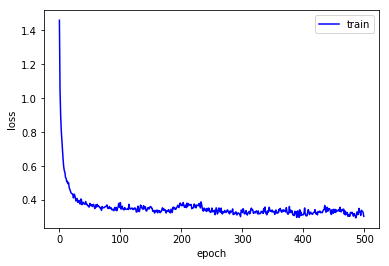

In [22]:
train_seq2seq(net, 500, train_iter, loss, optimizer, tgt_vocab,
        grad_clip_theta=1, device=torch.device('cuda'))

- predict

为了采用一个接着一个词元的方式预测输出序列，每个解码器当前时间步的输入都将来自于前一时间步的预 测词元。与训练类似，序列开始词元(“\<bos>”)在初始时间步被输入到解码器中,当输出序列的预测遇到序列结束词元(“<eos>”)时，预测就结束了。
![title](attachment/seq2seq.png)
    
    

In [23]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device=torch.device('cuda'), save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
                            src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor(
                [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使⽤具有预测最⾼可能性的词元，作为解码器在下⼀时间步的输⼊
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # ⼀旦序列结束词元被预测，输出序列的⽣成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [24]:
predict_seq2seq(net, 'he\'s clam', src_vocab, tgt_vocab, 10)

('il est <unk> .', [])

- Eval

BLEU（bilingual evaluation understudy）

我们可以通过与真实的标签序列进行比较来评估预测序列。虽然 [Papineni et al., 2002] 提出的BLEU (bilingual evaluation understudy)最先是用于评估机器翻译的结果，但现在它已经被广泛用于测量许多应用的输出序列的质量。

原则上说，对于预测序列中的任意n元语法(n-grams)，BLEU的评估都是这个n元
语法是否出现在标签序列中。

$$
BELU = exp(min(0, 1-\frac{len_{label}}{len_{predict}}))\prod_{n=1}^kp_n^{\frac{1}{2^n}}
$$

其中lenlabel表示标签序列中的词元数和 lenpred表示预测序列中的词元数，k是用于匹配的最⻓的n元语法。

另外，用pn 表示n元语法的精确度，它是两个数量的比值:第一个是预测序列与标签序列中匹配的n元语法的数 量，第二个是预测序列中n元语法的数量的比率。

当预测序列与标签序列完全相同时，BLEU为1, 由于n元语法越⻓则匹配难度越大，所以BLEU为更⻓的n元语法的精确度分配更大的权重。



In [25]:
import math

In [26]:
def bleu(pred_seq, label_seq, k): #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [27]:
t = predict_seq2seq(net, 'he\'s calm .', src_vocab, tgt_vocab, 10)
bleu(t[0], 'il est calme .', k=2)

0.6580370064762462

In [28]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
            net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => pred: {translation} => true: {fra}, bleu {bleu(translation, fra, k=2):.3f}')

go . => pred: va doucement ! => true: va !, bleu 0.000
i lost . => pred: je l'ai vu . => true: j'ai perdu ., bleu 0.000
he's calm . => pred: il est paresseux . => true: il est calme ., bleu 0.658
i'm home . => pred: je suis <unk> . => true: je suis chez moi ., bleu 0.512
